In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import urllib.request

%matplotlib inline
%load_ext autoreload
%autoreload 1

matplotlib.rcParams['font.family'] = 'IPAexGothic'
sns.set(font='IPAexGothic')

from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split


import math

In [2]:
if not os.path.exists("data"):
    os.mkdir("data")
url = "https://web.stanford.edu/~hastie/StatLearnSparsity_files/DATA/crime.txt" 
save_name = "data/crime.txt" 
urllib.request.urlretrieve(url, save_name)

('data/crime.txt', <http.client.HTTPMessage at 0x11e985b00>)

In [3]:
crime = pd.read_table("data/crime.txt",header=None)
crime.drop(columns= 1,inplace=True)

/Users/ippei/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [4]:
crime.columns=["y",1,2,3,4,5]

In [5]:
#説明変数の正規化
df = crime.copy()
target = df["y"].copy()
df.drop(columns="y",inplace=True)
for i in df.columns:
    df[i] = (df[i] - df[i].mean())/df[i].std()

In [6]:
target = (target - target.mean())/target.std()

In [7]:
#train test split
X_train,X_test,y_train,y_test =  train_test_split(df,target,train_size = 0.7,random_state = 1234)

/Users/ippei/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
#Lasso IC 実装
#AIC導出の関数
#log10alpha=[0,2.0]で動かす
from math import log
def LassoIC(X, y , eps=5e-3, alpha_min=0, alpha_max=2.0, n_alphas=10000, criterion = 'aic'):
    IC_list = []
    alphas = np.linspace(pow(10,alpha_min),pow(10,alpha_max),num=n_alphas)
    alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps, fit_intercept=False, alphas=alphas)
    n = len(X)     
    R = y[:, np.newaxis] - np.dot(X, coefs_lasso)  # residuals
    mean_squared_error = np.mean(R ** 2, axis=0)
    sigma2 = np.var(y)
    df = np.zeros(coefs_lasso.shape[1], dtype=np.int)
    
    for k, coef in enumerate(coefs_lasso.T):
        mask = np.abs(coef) > np.finfo(coef.dtype).eps
        if not np.any(mask):
            continue
        # get the number of degrees of freedom equal to:
        # Xc = X[:, mask]
        # Trace(Xc * inv(Xc.T, Xc) * Xc.T) ie the number of non-zero coefs
        df[k] = np.sum(mask)
        
    #criterion check
    if criterion == 'aic':
        K = 2
    elif criterion == 'bic':
        K = log(n)
    else:
        raise ValueError('criterion should be either aic or bic')
    
    eps64 = np.finfo('float64').eps
    IC = n * mean_squared_error / (sigma2 + eps64) + K * df
    best_n = np.argmin(IC)
    best_alpha = alphas_lasso[best_n]
    best_coef = coefs_lasso[:,best_n]

    return alphas_lasso, coefs_lasso, best_alpha, best_coef, IC

In [9]:
aic_alphas, aic_coefs, aic_best_alpha, aic_best_coef, AIC = LassoIC(X_train,y_train,alpha_min=-3.0, alpha_max= 0.1)
bic_alphas, bic_coefs, bic_best_alpha, bic_best_coef, BIC = LassoIC(X_train,y_train,alpha_min=-3.0, alpha_max= 0.1,criterion='bic')

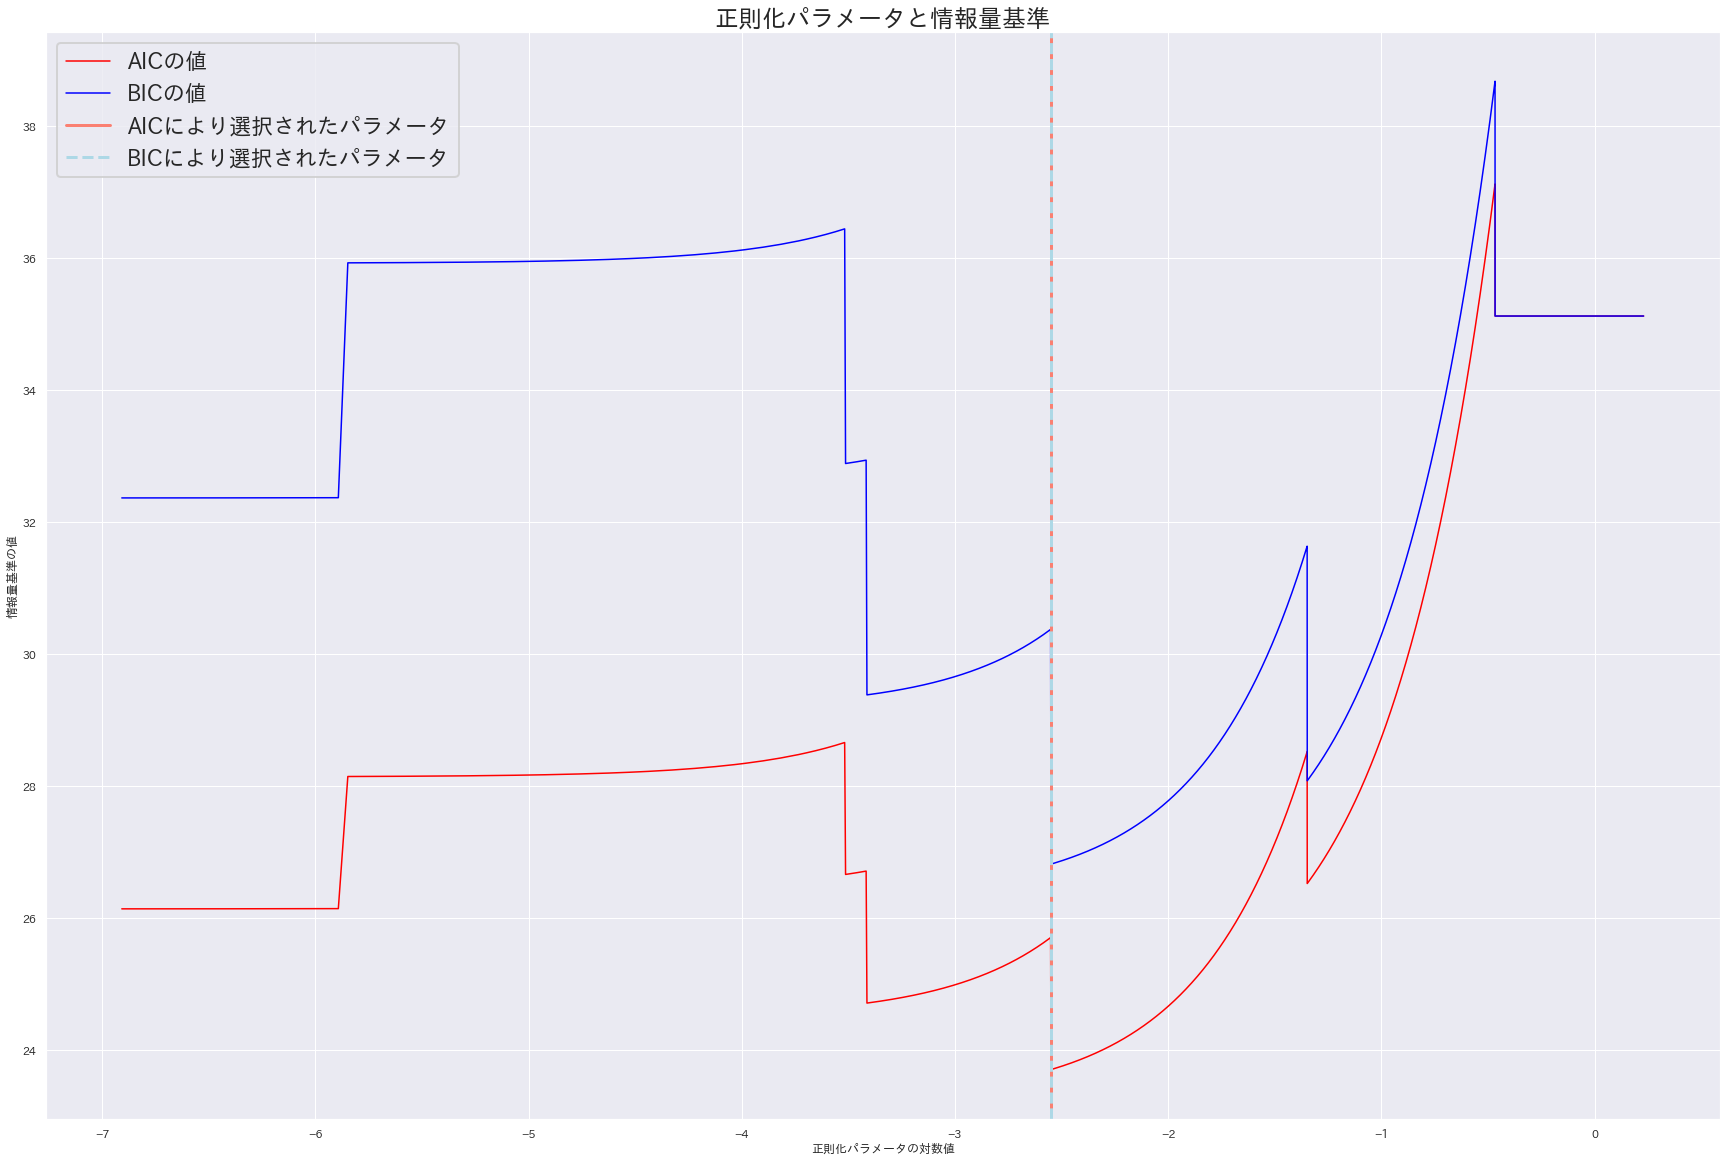

In [10]:
plt.figure(figsize=(30,20))
plt.plot(np.log(aic_alphas),AIC,c="red",label='AICの値')
plt.plot(np.log(bic_alphas),BIC,c="blue",label='BICの値')
plt.axvline(np.log(aic_best_alpha), color="salmon", linewidth=3,alpha = 1,label='AICにより選択されたパラメータ')
plt.axvline(np.log(bic_best_alpha), color="lightblue", linewidth=3,linestyle='--',label='BICにより選択されたパラメータ')
sns.set_context('poster')
plt.xlabel('正則化パラメータの対数値')
plt.ylabel('情報量基準の値')
plt.title('正則化パラメータと情報量基準')
plt.legend()
plt.show()

In [11]:
aic_lasso = linear_model.Lasso(alpha=aic_best_alpha)
aic_lasso.fit(X_train,y_train)
y_pred_aic = aic_lasso.predict(X_test)

bic_lasso = linear_model.Lasso(alpha=bic_best_alpha)
bic_lasso.fit(X_train,y_train)
y_pred_bic = bic_lasso.predict(X_test)

In [12]:
#LASSO with coordinate descent 
cd_model = linear_model.Lasso()
cd_model.fit(X_train, y_train)

#LASSOCV with coordinate descent 
cv_alphas = np.linspace(-3,0.1,num=100)
cd_model_cv = LassoCV(cv=10, alphas=pow(10,cv_alphas))
cd_model_cv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000e-03, 1.07476e-03, ..., 1.17135e+00, 1.25893e+00]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [13]:
y_pred_cd = cd_model.predict(X_test)
y_pred_cd_cv = cd_model_cv.predict(X_test)

In [14]:
#通常のlinear reg
lin = linear_model.LinearRegression()
lin.fit(X_train,y_train)
pred_lin = lin.predict(X_test)

In [15]:
lin.coef_

array([ 0.75067696, -0.55218467, -0.19821025, -0.05692921,  0.18522066])

In [16]:
#CVのプロット
x = np.log(cd_model_cv.alphas_)
y = np.array([i.mean() for i in cd_model_cv.mse_path_])
err = np.array([np.std(i)/math.sqrt(10) for i in cd_model_cv.mse_path_])
lambda_from_cv = x[np.argmin(y)]
min_cv = np.min(y)
err_from_cv = err[np.argmin(y)]

ose_lambda = -10000
standard = min_cv + err_from_cv
for counter,i in enumerate(y):
    if i < standard:
        if x[counter] > ose_lambda:
            ose_lambda = x[counter]

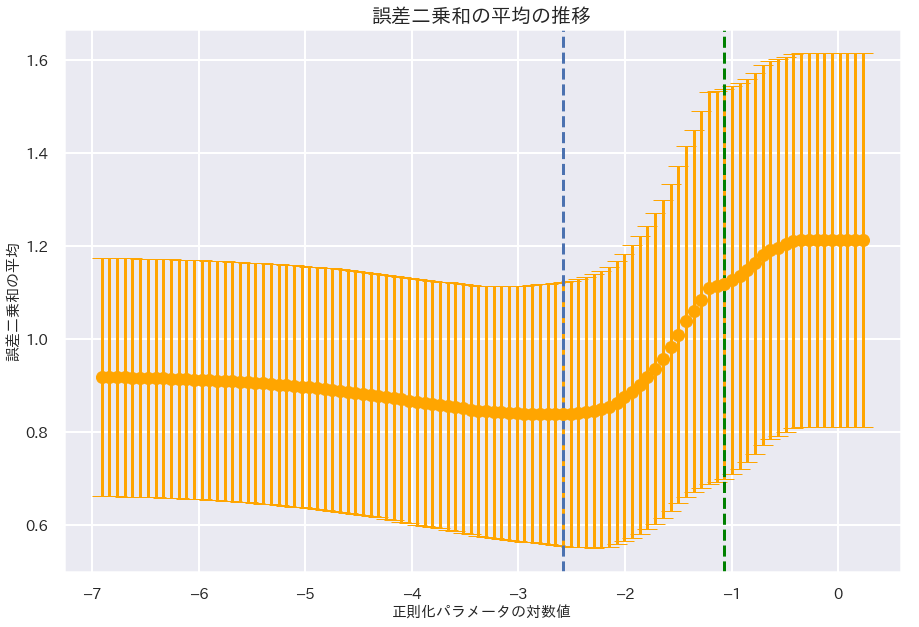

In [17]:
#CVの過程のプロット
plt.figure(figsize=(15,10))
plt.errorbar(x,y,yerr=err,fmt="o",capthick=1,capsize=10,color="orange",ecolor = "orange")
plt.axvline(x = lambda_from_cv,linestyle=("--"))
plt.axvline(x = ose_lambda,linestyle=("--"),color="green")
sns.set_context('notebook')
plt.title('誤差二乗和の平均の推移',fontsize=20)
plt.xlabel('正則化パラメータの対数値',fontsize=15)
plt.ylabel('誤差二乗和の平均',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.set_context('notebook')
plt.show()

In [18]:
ose_lambda

-1.0675621794790568

In [19]:
#ose（1標準誤差ルール）でのLASSO
ose_lasso = linear_model.Lasso(alpha=pow(10,ose_lambda))
ose_lasso.fit(X_train,y_train)

Lasso(alpha=0.08559291565383027, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
y_pred_ose = ose_lasso.predict(X_test)

In [21]:
print(cd_model.alpha,cd_model_cv.alpha_,aic_lasso.alpha,bic_lasso.alpha,ose_lasso.alpha)

1.0 0.07564633275546291 0.07811853959694215 0.07811853959694215 0.08559291565383027


In [22]:
print(cd_model.coef_,  
        cd_model_cv.coef_,aic_lasso.coef_,bic_lasso.coef_,ose_lasso.coef_,)

[ 0. -0.  0. -0. -0.] [ 0.58011933 -0.21167894 -0.          0.          0.        ] [ 0.57722833 -0.20874877 -0.          0.          0.        ] [ 0.57722833 -0.20874877 -0.          0.          0.        ] [ 0.56848778 -0.19988981  0.          0.          0.        ]


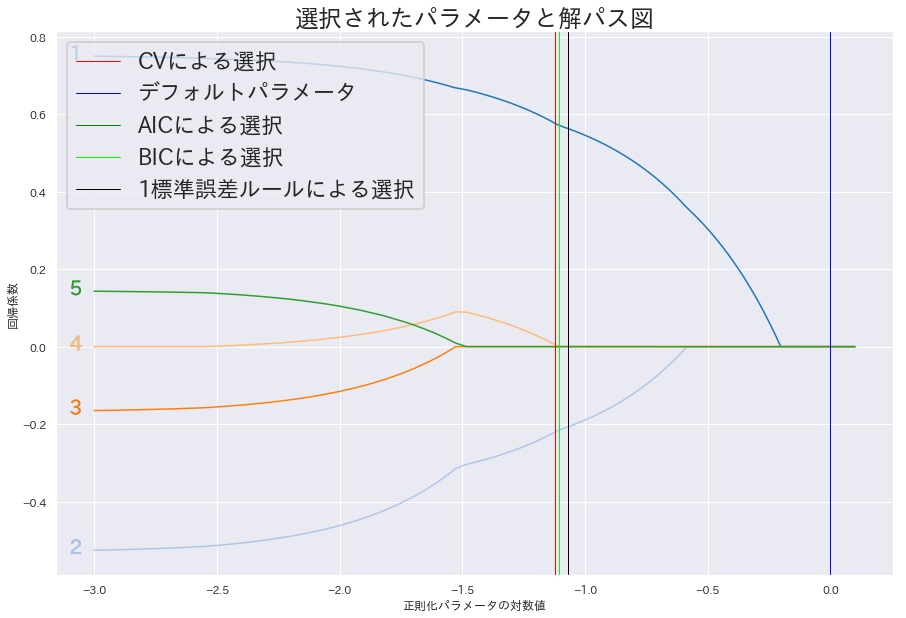

In [23]:
#解パス
plt.figure(figsize=(15,10))
for counter,(i,j) in enumerate(zip(aic_coefs,df.columns)):
    plt.plot(np.log10(aic_alphas),i, color = cm.tab20(counter))
    text = plt.text(-3.1,i[-1]-0.01, j, color = cm.tab20(counter),fontsize =20)
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground='black'),path_effects.Normal()])
plt.axvline(np.log10(cd_model_cv.alpha_), color="red", linewidth=1, label='CVによる選択')
plt.axvline(np.log10(cd_model.alpha), color="blue", linewidth=1, label='デフォルトパラメータ')
plt.axvline(np.log10(aic_best_alpha), color="green", linewidth=1, label='AICによる選択')
plt.axvline(np.log10(bic_best_alpha), color="lime", linewidth=1, label='BICによる選択')
plt.axvline(ose_lambda, color='black', linewidth=1, label='1標準誤差ルールによる選択')
#plt.xlim(-2.7,0)
sns.set_context('poster')
plt.title('選択されたパラメータと解パス図')
plt.xlabel('正則化パラメータの対数値')
plt.ylabel('回帰係数')
plt.legend()
plt.show()

In [24]:
#それぞれのモデルのRscore
modelcdR = r2_score(y_test,y_pred_cd)
modelcdcvR = r2_score(y_test,y_pred_cd_cv)
oseR = r2_score(y_test,y_pred_ose)
linR = r2_score(y_test, pred_lin)
aicR = r2_score(y_test, y_pred_aic)
bicR = r2_score(y_test, y_pred_bic)
print(modelcdR,modelcdcvR,oseR,linR,aicR,bicR)

-0.05004169539057135 -0.10973664933436655 -0.09688063049520546 -0.5257573157519257 -0.10648322276433242 -0.10648322276433242


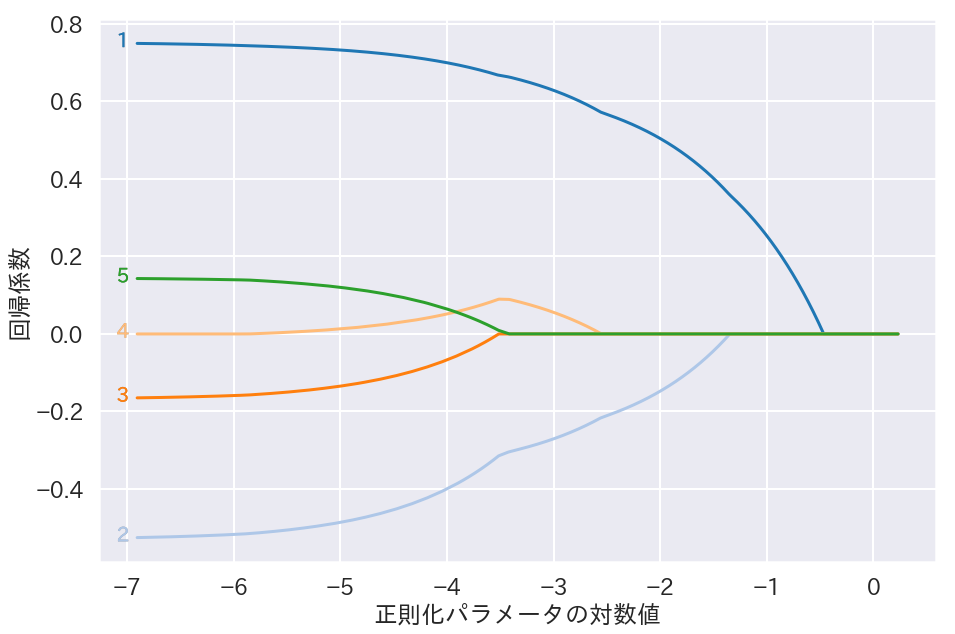

In [25]:
#解パスのみ
plt.figure(figsize=(15,10))
for counter,(i,j) in enumerate(zip(aic_coefs,df.columns)):
    plt.plot(np.log(aic_alphas),i, color = cm.tab20(counter))
    text = plt.text(-7.1,i[-1]-0.01, j, color = cm.tab20(counter),fontsize =20)
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground='black'),path_effects.Normal()])
#plt.xlim(-2.7,0)
#plt.legend()
sns.set_context('poster')
plt.xlabel('正則化パラメータの対数値')
plt.ylabel('回帰係数')
plt.show()